In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
print('import done!')

import done!


In [40]:
data = pd.read_csv('train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


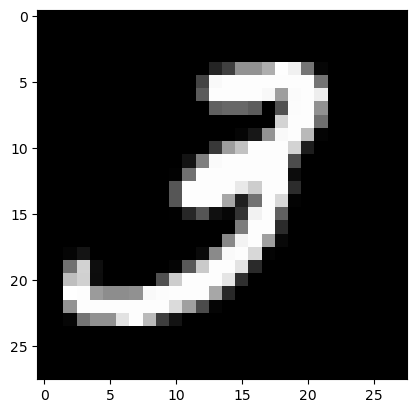

In [41]:
parent_data = np.array(data)
np.random.shuffle(parent_data)

X_labels, X_train = parent_data[:40000, :1].flatten(), parent_data[:40000, 1:].T /255
Y_dev, X_dev = parent_data[40000:, :1].flatten(), parent_data[40000:, 1:].T /255

plt.imshow(X_train[:, 0].reshape(28, 28), cmap='gray') # showing one image as sample

In [55]:
class NeuralNetwork:
    def init_wb(self, hidden_l: int, neurons: int):
        const, lst_wb = 0.5, []
        for i in range(hidden_l):
            W = np.random.rand(neurons, neurons)
            B = np.random.rand(neurons, 1)
            
            if i == 0:
                W = np.random.rand(neurons, 784)
                B = np.random.rand(neurons, 1)
            
            lst_wb.append([W - const, B - const])
            
        else:
            W = np.random.rand(10, neurons)
            B = np.random.rand(10, 1)
            
            lst_wb.append([W - const, B - const])
        
        return lst_wb
    
    def softmax_on_Y(self, Z):
        return np.exp(Z)/sum(np.exp(Z))
    
    def RelU_activation(self, Z):
        return np.maximum(0, Z)
    
    def forward_propagation(self, lst_wb: list, X):
        lst_za, prev_l = [], X
        for i in range(len(lst_wb) - 1):
            W, B = lst_wb[i][0], lst_wb[i][1]
            
            Z = W.dot(prev_l) + B
            A = self.RelU_activation(Z)
            
            lst_za.append([Z, A])
            prev_l = A
            
        else:
            W_last, B_last = lst_wb[-1][0], lst_wb[-1][1]
            prev_a = lst_za[-1][1]
            
            Z = W_last.dot(prev_a) + B_last
            A = self.softmax_on_Y(Z)
            
            lst_za.append([Z, A])
        
        return lst_za
        
    def RelU_derivation(self, Z):
        return Z > 0
    
    def error_backpropagation(self, lst_za, lst_wb):
        expected_Y, size = self.one_hot_Y()
        softmax_activation = lst_za[-1][1]
        
        
        cost_derivative = (softmax_activation - expected_Y) * 2/size # MSE
        error_in_l, derivation_output = cost_derivative, []
        
        for index, each in enumerate(lst_za):
            if index == len(lst_za) - 1:
                prev_activation = X_train
            else:
                prev_activation = lst_za[-(index + 2)][1]
            
            dW = error_in_l.dot(prev_activation.T) 
            dB = np.sum(error_in_l) 
            derivation_output.append([dW, dB])
            
            if index != len(lst_za) - 1:
                W, Z = lst_wb[-(index + 1)][0], lst_za[-(index + 2)][0]
                error_in_l = W.T.dot(error_in_l) * self.RelU_derivation(Z)
        
        derivation_output.reverse()
        return derivation_output
                
    def one_hot_Y(self):
        size = X_train.shape[1]
        arr = np.zeros((size, 10))
        arr[list(range(size)), X_labels] = 1
        
        return arr.T, size
    
    def updating_wb(self, alpha, lst_wb, derivation_output):
        for index, each in enumerate(lst_wb):
            W = each[0]
            B = each[1]
            
            lst_wb[index][0] = W - alpha * derivation_output[index][0]
            lst_wb[index][1] = B - alpha * derivation_output[index][1]
            
        return lst_wb
    
    def prediction_accur(self, softmax_Y):
        indices_output = np.argmax(softmax_Y, axis=0)
        percentage = np.sum(indices_output == X_labels)/400
        
        return percentage, indices_output
    
    def store_final_in_txt(self, lst_wb:list):
        import shutil, os
        shutil.rmtree('learned_wb')
        os.mkdir('learned_wb')
        for index, each in enumerate(lst_wb):
            W = each[0]
            B = each[1]

            file_w = f'learned_wb/{index}_W.txt'
            file_b = f'learned_wb/{index}_WB.txt'

            np.savetxt(file_w, W)
            np.savetxt(file_b, B)
            
    def gradient_descent(self, iteration, learning_rate, neurons, hidden_l):
        randomized_wb = self.init_wb(hidden_l, neurons)
        lst_wb = randomized_wb
        for i in range(1, iteration + 1):
            lst_za = self.forward_propagation(lst_wb, X_train)
            derivation_output = self.error_backpropagation(lst_za, lst_wb)
            
            updated_wb = self.updating_wb(learning_rate, lst_wb, derivation_output)
            lst_wb = updated_wb
            
            print(f'iteration: {i}')
            percentage, indices_output = self.prediction_accur(lst_za[-1][1])
            loss = np.sum(np.square(np.subtract(lst_za[-1][1], neural_network.one_hot_Y()[0]))) / 40000
            print('Actual Output:', X_labels, 'Prediction Output:', indices_output)
            print(f'predicted percentage correctness: {percentage}', f'Loss: {loss}\n')
        
        self.store_final_in_txt(lst_wb)
        return lst_wb, lst_za

In [58]:
if __name__ == '__main__':
    neural_network = NeuralNetwork()
    lst_wb, lst_za = neural_network.gradient_descent(100, .001, 128, 2)
    softma = neural_network.forward_propagation(lst_wb, X_dev)[-1][1]
    neural_network.store_final_in_txt(lst_wb=lst_wb)

iteration: 1
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 9 9 9]
predicted percentage correctness: 10.46 Loss: 1.7288985952557963

iteration: 2
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 9 0 9]
predicted percentage correctness: 10.3975 Loss: 1.6911255114395165

iteration: 3
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 9 0 7]
predicted percentage correctness: 10.7175 Loss: 1.6451213795261044

iteration: 4
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 5 0 7]
predicted percentage correctness: 11.105 Loss: 1.6132297725210059

iteration: 5
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 5 0 7]
predicted percentage correctness: 11.415 Loss: 1.5961451348108664

iteration: 6
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 5 0 7]
predicted percentage correctness: 11.5575 Loss: 1.5853057138630697

iteration: 7
Actual Output: [3 6 0 ... 1 6 3] Prediction Output: [9 9 9 ... 5 0 7]
predicted perce